# Explore here

In [7]:
import requests
import zipfile
import io
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import seaborn as sns

In [8]:
# 1. DESCARGA Y EXTRACCIÓN DE DATOS 
print("Descargando dataset...")
url = "https://storage.googleapis.com/datascience-materials/dogs-vs-cats.zip"
response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("../data")

print("Dataset descargado y extraído exitosamente")



Descargando dataset...
Dataset descargado y extraído exitosamente


Encontradas 12500 imágenes de perros y 12500 imágenes de gatos


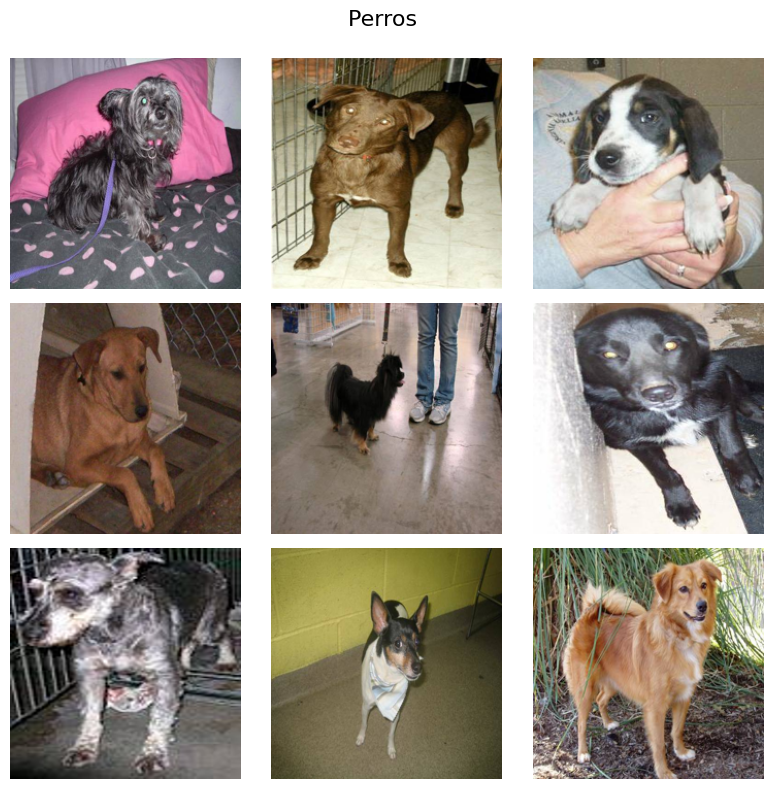

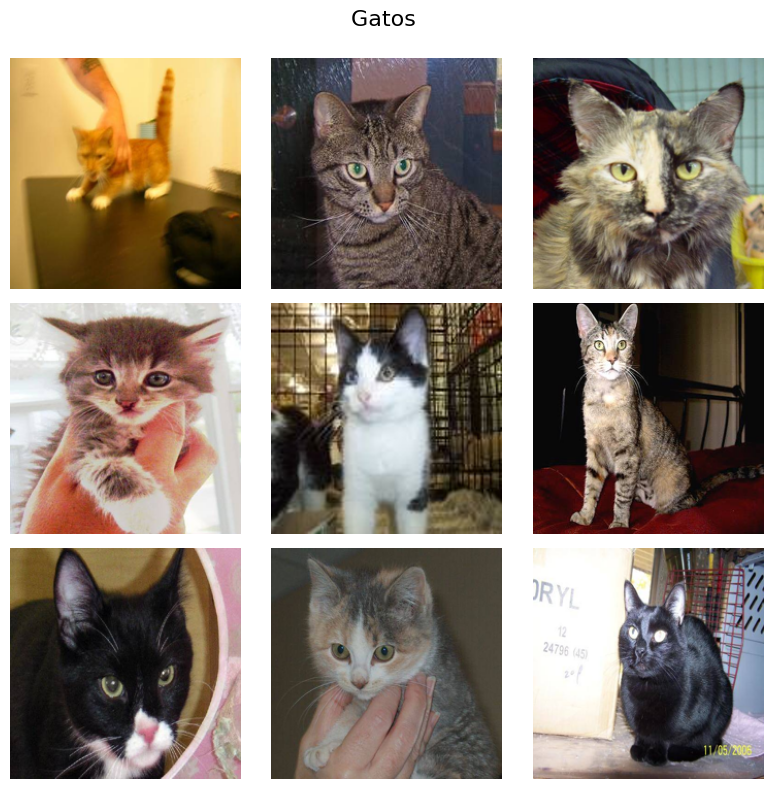

In [9]:


# 2. EXPLORACIÓN Y PREPARACIÓN DE DATOS 
data_dir = "../data"

# Busca recursivamente todas las imágenes .jpg bajo data_dir
image_paths = glob.glob(os.path.join(data_dir, "**", "*.jpg"), recursive=True)

# Filtra por 'dog' y 'cat' en el nombre de archivo (sin distinguir mayúsculas/minúsculas)
dog_paths = sorted([p for p in image_paths if 'dog' in os.path.basename(p).lower()])
cat_paths = sorted([p for p in image_paths if 'cat' in os.path.basename(p).lower()])

print(f"Encontradas {len(dog_paths)} imágenes de perros y {len(cat_paths)} imágenes de gatos")

def collect_first_n_valid(paths, n):
    """Recorre la lista y devuelve las primeras n rutas de imágenes que se pueden abrir correctamente."""
    collected = []
    for p in paths:
        if len(collected) >= n:
            break
        try:
            with Image.open(p) as im:
                im.verify()  # verifica que la imagen no esté corrupta
            collected.append(p)
        except Exception:
            # si hay error (imagen corrupta, formato incompatible, etc.), la saltamos
            continue
    return collected

def plot_grid(image_paths, title, size=(224, 224)):
    n = len(image_paths)
    if n == 0:
        print(f"No hay imágenes para: {title}")
        return
    # Esperamos exactamente 9, pero si hay menos, ajustamos la cuadrícula
    rows = cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    axes = axes.flatten()
    for i in range(rows * cols):
        ax = axes[i]
        if i < n:
            try:
                img = Image.open(image_paths[i]).convert('RGB')
                img = img.resize(size)
                ax.imshow(img)
            except Exception as e:
                ax.text(0.5, 0.5, "Error al abrir\nimagen", ha='center', va='center')
        ax.axis('off')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # espacio para el título
    plt.show()

# Obtener las primeras 9 válidas de cada clase (recorriendo la lista)
first9_dogs = collect_first_n_valid(dog_paths, 9)
first9_cats = collect_first_n_valid(cat_paths, 9)

# Mostrar
plot_grid(first9_dogs, "Perros ")
plot_grid(first9_cats, "Gatos ")

In [12]:


#  3. CREAR ARRAYS X E Y 
size = (224, 224)

# Si ya existen las listas first100_dogs / first100_cats (desde pasos anteriores), las usamos.
# Si no, intentamos leer desde el directorio generado "../data/sample_200/train/"
try:
    dog_paths = first100_dogs
    cat_paths = first100_cats
except NameError:
    subset_dir = "../data/sample_200"
    if os.path.exists(subset_dir):
        dog_paths = sorted(glob.glob(os.path.join(subset_dir, "train", "dog", "*.jpg")))
        cat_paths = sorted(glob.glob(os.path.join(subset_dir, "train", "cat", "*.jpg")))
    else:
        # Usar las listas originales si no existe el subset
        pass



In [ ]:

# 4. DIVISIÓN DE DATOS 
# Parámetros de particionado
test_size = 0.2   # fracción total para test
val_size = 0.1    # fracción total para validación
random_state = 123
batch_size = 16

# Calculamos la fracción relativa de validación sobre el conjunto restante después de separar test
val_relative = val_size / (1.0 - test_size)

# 1) Separar test
x_temp, x_test, y_temp, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=random_state
)

# 2) Separar train y validation desde x_temp
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=val_relative, stratify=y_temp, random_state=random_state
)



NameError: name 'X' is not defined

In [ ]:


print(
    "Shapes -> train:", x_train.shape, y_train.shape,
    " val:", x_val.shape, y_val.shape,
    " test:", x_test.shape, y_test.shape
)

In [ ]:
# Construir X e y asegurando correspondencia (evitamos imágenes corruptas)
X_list = []
y_list = []

def append_images(paths, label):
    for p in paths:
        try:
            img = Image.open(p).convert("RGB").resize(size)
            arr = np.asarray(img, dtype=np.float32) / 255.0  # normaliza a [0,1]
            X_list.append(arr)
            y_list.append(label)
        except Exception:
            # saltar imágenes inválidas
            continue

print("Procesando imágenes...")
append_images(cat_paths, 0)   # gato = 0
append_images(dog_paths, 1)   # perro = 1

# Convertir a arrays numpy
X = np.stack(X_list, axis=0) if len(X_list) > 0 else np.empty((0, *size, 3), dtype=np.float32)
y = np.array(y_list, dtype=np.int32)

print(f"X shape: {X.shape}, dtype: {X.dtype}")
print(f"y shape: {y.shape}, unique labels: {np.unique(y)}")

In [ ]:

# ===== 5. DATA AUGMENTATION =====
# ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Para validation y test no queremos augmentaciones
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Crear generadores
train_data = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
val_data   = val_datagen.flow(x_val,   y_val,   batch_size=batch_size, shuffle=False)
test_data  = test_datagen.flow(x_test,  y_test,  batch_size=batch_size, shuffle=False)

print("Batches de entrenamiento:", len(train_data))
print("Batches de validación:", len(val_data))
print("Batches de test:", len(test_data))

In [ ]:


# ===== 6. CONSTRUCCIÓN DEL MODELO VGG16 =====
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

# Modelo CNN liviano personalizado
model = Sequential()

# Bloque 1
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)))
model.add(MaxPool2D((2,2)))

# Bloque 2
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

# Bloque 3
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

# Bloque 4
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

# Capas finales
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # 2 clases: gato/perro

# Resumen y compilación
model.summary()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # para labels enteros (0,1)
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ===== 7. CALLBACKS Y ENTRENAMIENTO =====
# Callbacks para mejorar el entrenamiento
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
# Entrenamiento liviano (pocas épocas para demostración)
print("\n===== INICIANDO ENTRENAMIENTO =====")
epochs = 10  # Entrenamiento liviano

history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)



ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# ===== 8. EVALUACIÓN Y PREDICCIONES EN TEST =====


# 1) Cargar el mejor modelo guardado (si existe)
model_path = "best_model.h5"
if os.path.exists(model_path):
    print(f"Cargando modelo desde {model_path} ...")
    model = load_model(model_path)
else:
    print(f"No se encontró {model_path}, se usará el modelo en memoria (últimas pesas).")

# 2) Predicciones sobre el conjunto de test
if x_test.shape[0] == 0:
    print("Conjunto de test vacío. No se puede evaluar.")
else:
    print("Generando predicciones sobre test...")
    # Aseguramos que test_data no esté shuffle y corresponda a y_test (ya lo definimos así)
    preds_proba = model.predict(test_data, verbose=1)  # shape (n_samples, 2)
    y_pred = np.argmax(preds_proba, axis=1)
    y_true = y_test  # ya disponible

    # 3) Métricas clásicas
    acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy en test: {acc:.4f}\n")
    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=['cat','dog']))

    # 4) Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['cat','dog'], yticklabels=['cat','dog'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # 5) ROC / AUC (tratamos como problema binario usando la probabilidad de la clase 1 = perro)
    try:
        y_score = preds_proba[:, 1]
        auc = roc_auc_score(y_true, y_score)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        plt.plot([0,1], [0,1], '--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (test)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
        print(f"AUC: {auc:.4f}")
    except Exception as e:
        print("No se pudo calcular ROC/AUC:", e)

    # 6) Mostrar algunas imágenes mal clasificadas
    mis_idx = np.where(y_pred != y_true)[0]
    print(f"Total de muestras mal clasificadas: {len(mis_idx)}")
    n_show = min(9, len(mis_idx))
    if n_show > 0:
        plt.figure(figsize=(9,9))
        for i, idx in enumerate(mis_idx[:n_show]):
            ax = plt.subplot(3, 3, i+1)
            img = x_test[idx]
            # img está normalizado en [0,1]
            ax.imshow((img * 255).astype(np.uint8))
            ax.axis('off')
            ax.set_title(f"True: {'dog' if y_true[idx]==1 else 'cat'}\nPred: {'dog' if y_pred[idx]==1 else 'cat'}")
        plt.suptitle("Ejemplos mal clasificados")
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
    else:
        print("No hay muestras mal clasificadas para mostrar.")

In [ ]:
# Ver distribución de etiquetas en splits

import numpy as np
print("Train distrib:", np.bincount(y_train))
print("Val   distrib:", np.bincount(y_val))
print("Test  distrib:", np.bincount(y_test))

In [ ]:
# curvas de entrenamiento
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

Analisis de resultados: Interpretación:

El modelo está aprendiendo (train loss baja y train acc sube) pero no generaliza bien al val/test (val acc estancada en 0.5).
La combinación val_loss ≥ train_loss + val_acc estable/baja sugiere que hay poca capacidad de generalización: puede ser underfitting (modelo demasiado simple) o, más probablemente dada la diferencia pequeña entre pérdidas, problema en los datos (etiquetas, balanceo) o selección de umbral.
El pico en val_loss y la caída brusca de val_acc en la última época apuntan a inestabilidad — tal vez por poca data, batch-to-batch ruidoso, o overfitting local al train set en ciertas épocas.
El hecho de que en test el modelo predice siempre “dog” (precision cat = 0) corrobora que hay un sesgo fuerte en las predicciones (threshold 0.5), aunque el AUC=0.635 indica que las probabilidades sí contienen señal útil.
Causas más probables (priorizadas)

Desbalance o errores en las etiquetas (muy frecuente).
Dataset demasiado pequeño / muy ruidoso → overfitting o inestabilidad en validación.
Pipeline con bug (etiquetas mezcladas) — chequear correspondencias imágenes->labels.
Arquitectura/regularización no adecuada (dropout alto, pocos datos para entrenar desde cero).
Umbral por defecto (0.5) no es apropiado aunque el modelo tenga ranking (AUC>0.5).

In [ ]:
# Histogram de probabilidades predicted
probs = preds_proba[:, 1]  # prob de "dog"
plt.hist(probs, bins=20)
plt.xlabel('Probabilidad clase dog'); plt.ylabel('Count'); plt.title('Distribución de probabilidades')
plt.show()
print("Probs mean:", probs.mean(), "min/max:", probs.min(), probs.max())

Analisis de resultados:
Muestra que el modelo esta sesgado hacia perro 

In [ ]:
# Bsca el umbral que maximiza F!
from sklearn.metrics import f1_score, classification_report

best_thr, best_f1 = 0.0, -1
for thr in np.linspace(0,1,101):
    y_pred_thr = (probs >= thr).astype(int)
    f = f1_score(y_test, y_pred_thr)
    if f > best_f1:
        best_f1 = f; best_thr = thr

print("Mejor umbral:", best_thr, "mejor F1:", best_f1)
y_pred_best = (probs >= best_thr).astype(int)
print(classification_report(y_test, y_pred_best, target_names=['cat','dog']))